# Loan Default Risk Assessment — Model Notebook

This notebook trains **three models** for loan assessment. Each model section follows the same flow: **what we use to train** → **train** → **save** → **visualizations (incl. confusion matrix or metrics)** → **test**.

## Contents
1. **Install dependencies** — required packages
2. **Load dataset** — from `datasets/` or Kaggle
3. **Explore dataset** — columns, targets, missing values
4. **Data visualization** — distributions, correlations
5. **Clean dataset** — missing values, outliers; save `loan_cleaned.csv`
6. **Preprocess and split** — encode, scale, train/validation split
7. **Model 1: Loan Approval & Denial** — explain → train → save → confusion matrix & metrics → test
8. **Model 2: Credit Score Risk Assessment** — explain → train → save → performance metrics & plots → test
9. **Model 3: Loan Recommendation** — explain → train → save → performance metrics & plots → test


## 1. Install dependencies

**Purpose:** Install required Python packages (pandas, scikit-learn, matplotlib, seaborn, kagglehub) used in this notebook. Run once.

In [ ]:
# Purpose: Install dependencies (run this cell once)
# Kaggle API: place kaggle.json in ~/.kaggle/ or set KAGGLE_USERNAME / KAGGLE_KEY
!pip install -q kagglehub pandas scikit-learn xgboost matplotlib seaborn


[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Load the dataset

**Purpose:** Load the loan dataset from the `datasets/` folder (or from Kaggle if no local CSV exists). Outputs `df` (raw DataFrame) and shows shape and first rows.

In [ ]:
# Purpose: Load CSV from datasets/ or Kaggle; create df and DATASETS_DIR
import os
import pandas as pd
from pathlib import Path

DATASETS_DIR = Path("datasets")
DATASETS_DIR.mkdir(exist_ok=True)

# List CSV files in datasets folder (data used to train the ML model)
csv_local = sorted(DATASETS_DIR.glob("*.csv"))
print("CSV files in datasets folder:", [f.name for f in csv_local] if csv_local else "None")

# Load from datasets folder first; fallback to Kaggle (kagglehub)
if csv_local:
    # Prefer Loan.csv if present, else first CSV
    csv_path = DATASETS_DIR / "Loan.csv" if (DATASETS_DIR / "Loan.csv").exists() else csv_local[0]
    print("Loading from datasets folder:", csv_path)
    df = pd.read_csv(csv_path)
else:
    import kagglehub
    path = kagglehub.dataset_download("lorenzozoppelletto/financial-risk-for-loan-approval")
    path_obj = Path(path)
    csv_files = list(path_obj.glob("*.csv")) or list(path_obj.rglob("*.csv"))
    if not csv_files:
        raise FileNotFoundError(f"No CSV in {path}. Put a CSV in {DATASETS_DIR} or use Kaggle.")
    csv_path = csv_files[0]
    print("Loading from Kaggle:", csv_path)
    df = pd.read_csv(csv_path)

print("Shape:", df.shape)
df.head(10)

CSV files in datasets folder: ['Loan.csv', 'loan_cleaned.csv']
Loading from datasets folder: datasets\Loan.csv
Shape: (20000, 36)


,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2018-01-01,45,39948,617,Employed,Master,22,13152,48,Married,...,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,2018-01-02,38,39709,628,Employed,Associate,15,26045,48,Single,...,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,2018-01-03,47,40724,570,Employed,Bachelor,26,17627,36,Married,...,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0
3,2018-01-04,58,69084,545,Employed,High School,34,37898,96,Single,...,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,0,54.0
4,2018-01-05,37,103264,594,Employed,Associate,17,9184,36,Married,...,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210,1,36.0
5,2018-01-06,37,178310,626,Self-Employed,Master,16,15433,72,Married,...,14859.166667,0.756079,5,27071,0.217433,0.217601,385.577074,0.075211,1,44.0
6,2018-01-07,58,51250,564,Employed,High School,39,12741,48,Married,...,4270.833333,0.884275,5,21730,0.225741,0.205271,391.300352,0.170529,0,50.0
7,2018-01-08,49,97345,516,Employed,High School,23,19634,12,Divorced,...,8112.083333,0.933492,5,38621,0.226634,0.209113,1827.360055,0.260767,1,42.4
8,2018-01-09,34,116841,603,Employed,Bachelor,12,55353,60,Divorced,...,9736.750000,0.728397,3,7711,0.258853,0.291539,1762.199026,0.246509,0,61.0
9,2018-01-10,46,40615,612,Employed,Associate,19,25443,12,Married,...,3384.583333,0.615323,3,116812,0.184443,0.197271,2353.577424,0.903384,0,53.0


## 3. Explore the dataset

**Purpose:** Define target column names and inspect columns, target distributions, dtypes, and missing values.

In [ ]:
# Purpose: Set targets (LoanApproved, RiskScore) and print columns, targets, info, missing counts
TARGET_CLASS = "LoanApproved"
TARGET_SCORE = "RiskScore"

print("Columns:", df.columns.tolist())
print("\nTarget (classification):", TARGET_CLASS)
if TARGET_CLASS in df.columns:
    print(df[TARGET_CLASS].value_counts())
print("\nTarget (regression):", TARGET_SCORE)
if TARGET_SCORE in df.columns:
    print(df[TARGET_SCORE].describe())
print("\nInfo & missing:")
print(df.info())
print("\nMissing per column:")
print(df.isnull().sum())

Columns: ['ApplicationDate', 'Age', 'AnnualIncome', 'CreditScore', 'EmploymentStatus', 'EducationLevel', 'Experience', 'LoanAmount', 'LoanDuration', 'MaritalStatus', 'NumberOfDependents', 'HomeOwnershipStatus', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'LoanPurpose', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'LoanApproved', 'RiskScore']

Target (classification): LoanApproved
LoanApproved
0    15220
1     4780
Name: count, dtype: int64

Target (regression): RiskScore
count    20000.000000
mean        50.766780
std          7.778262
min         28.800000
25%         46.000000
50%         52.000000
75%         56.000000
ma

### 3.1 Data visualization and data engineering

**Purpose:** Plot (1) missing values per column, (2) target distributions (LoanApproved, RiskScore), (3) distributions of key numeric features, (4) correlation heatmap of all numeric columns.

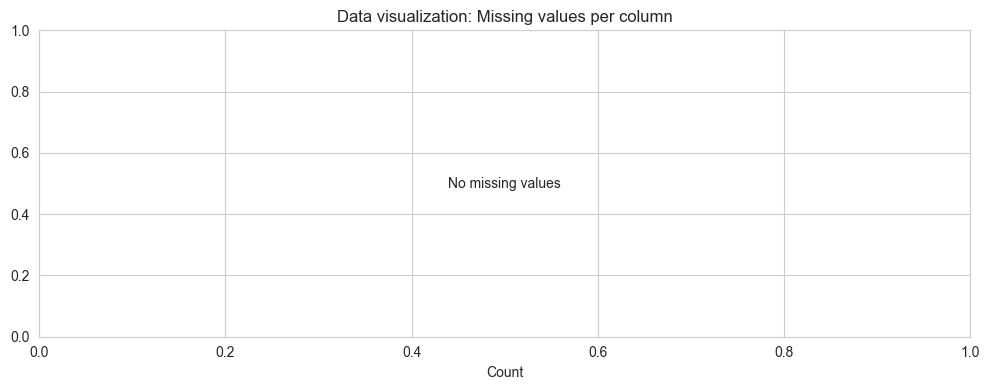

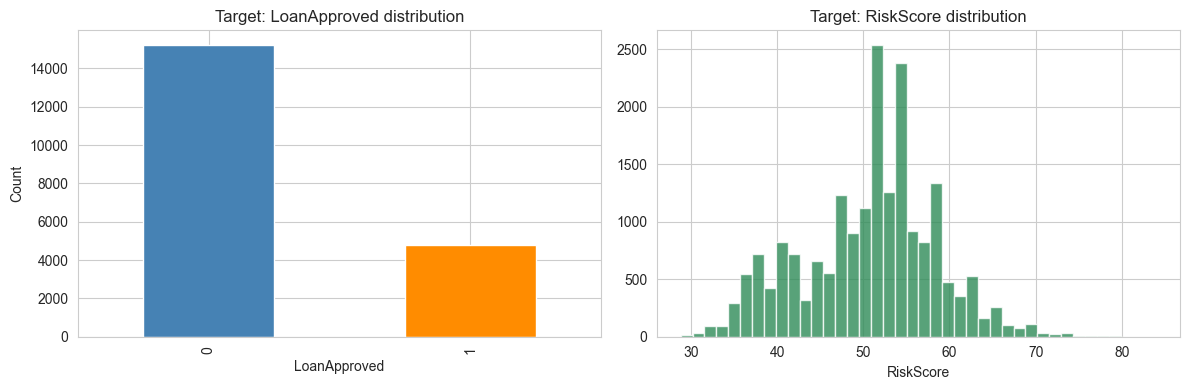

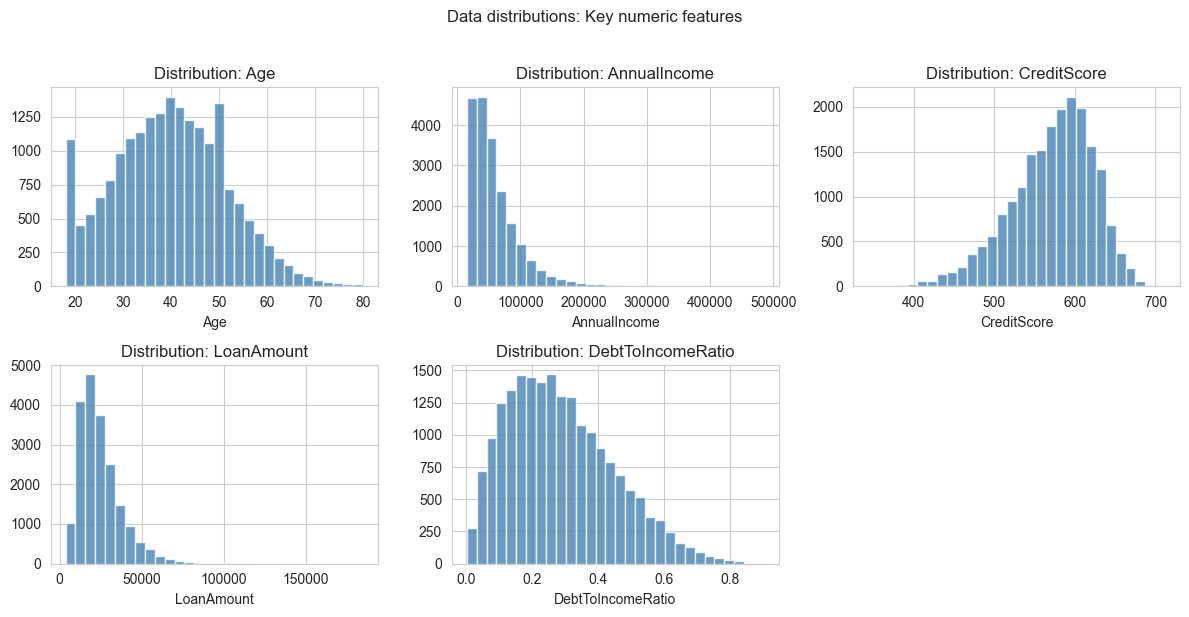

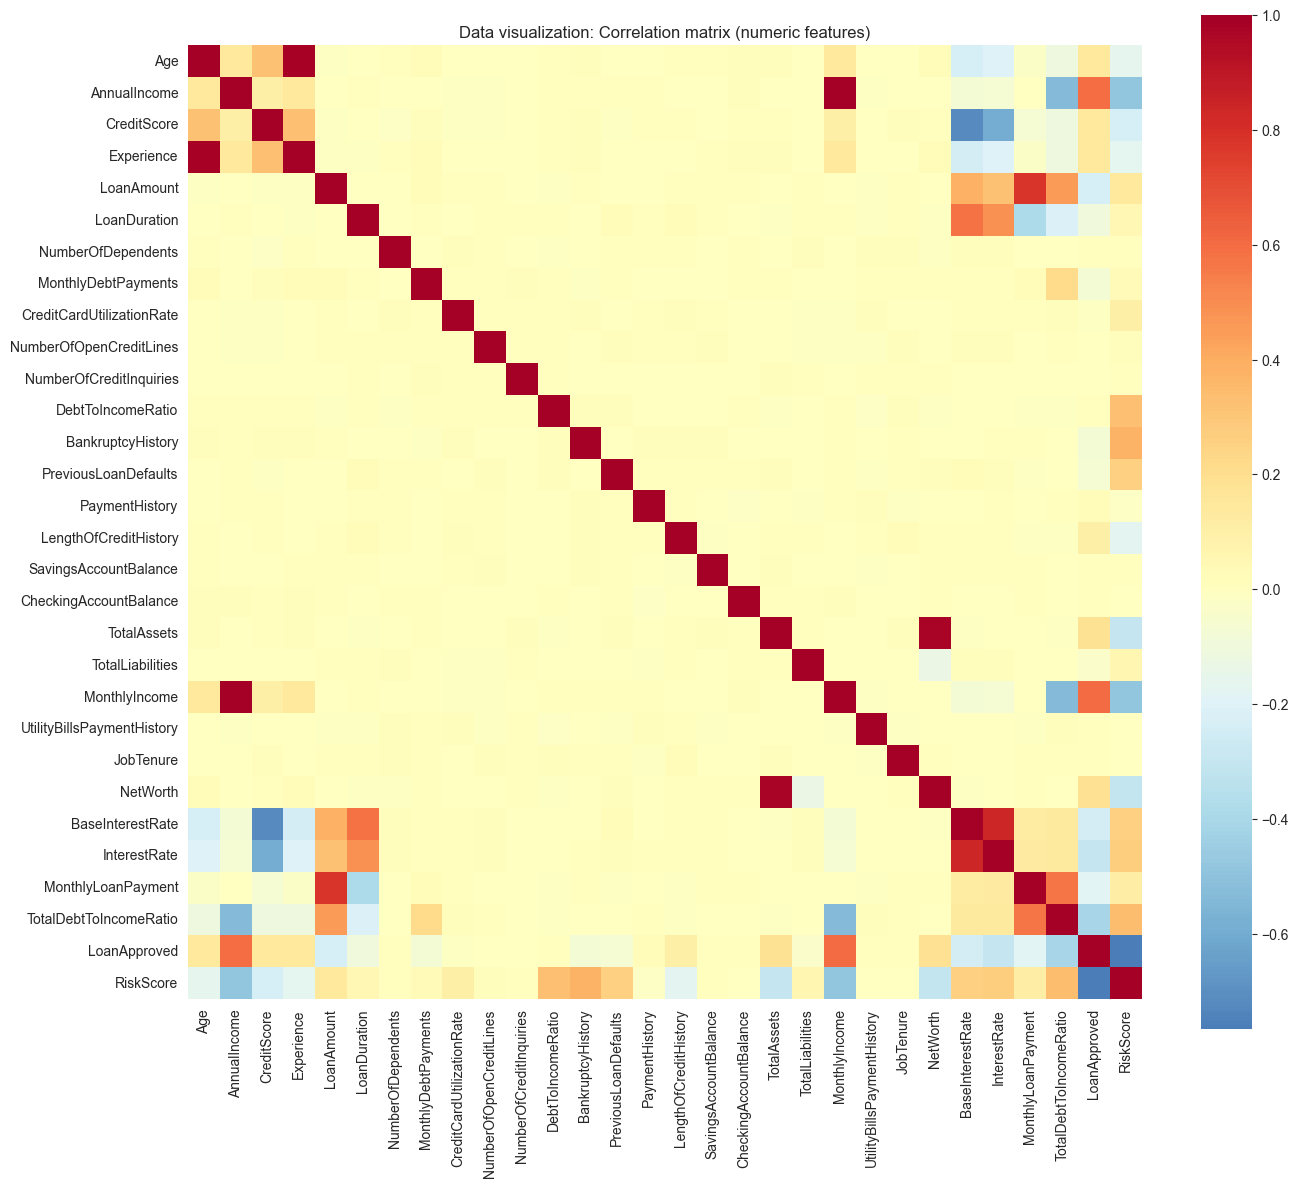

In [ ]:
# Purpose: Plot missing values, target distributions, feature distributions, and correlation matrix
# Install matplotlib/seaborn if missing (or run Section 1 first)
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
except ModuleNotFoundError as e:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "matplotlib", "seaborn"])
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

sns.set_style("whitegrid")

# --- 1. Missing values per column ---
fig1, ax1 = plt.subplots(figsize=(10, 4))
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if len(missing) > 0:
    missing.head(20).plot(kind="barh", ax=ax1, color="coral", alpha=0.8)
else:
    ax1.text(0.5, 0.5, "No missing values", ha="center", va="center", transform=ax1.transAxes)
ax1.set_title("Data visualization: Missing values per column")
ax1.set_xlabel("Count")
plt.tight_layout()
plt.show()

# --- 2. Target distributions (LoanApproved & RiskScore) ---
fig2, axes2 = plt.subplots(1, 2, figsize=(12, 4))
if TARGET_CLASS in df.columns:
    df[TARGET_CLASS].value_counts().plot(kind="bar", ax=axes2[0], color=["steelblue", "darkorange"])
    axes2[0].set_title("Target: LoanApproved distribution")
    axes2[0].set_xlabel("LoanApproved")
    axes2[0].set_ylabel("Count")
if TARGET_SCORE in df.columns:
    df[TARGET_SCORE].dropna().hist(ax=axes2[1], bins=40, color="seagreen", alpha=0.8, edgecolor="white")
    axes2[1].set_title("Target: RiskScore distribution")
    axes2[1].set_xlabel("RiskScore")
plt.tight_layout()
plt.show()

# --- 3. Key numeric feature distributions ---
key_numeric = [c for c in ["Age", "AnnualIncome", "CreditScore", "LoanAmount", "DebtToIncomeRatio"] if c in df.columns]
if key_numeric:
    n_plots = len(key_numeric)
    n_cols = 3
    n_rows = (n_plots + n_cols - 1) // n_cols
    fig3, axes3 = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
    axes3 = np.atleast_2d(axes3)
    for i, col in enumerate(key_numeric):
        r, c = i // n_cols, i % n_cols
        df[col].dropna().hist(ax=axes3[r, c], bins=30, color="steelblue", alpha=0.8, edgecolor="white")
        axes3[r, c].set_title(f"Distribution: {col}")
        axes3[r, c].set_xlabel(col)
    for j in range(i + 1, n_rows * n_cols):
        r, c = j // n_cols, j % n_cols
        axes3[r, c].set_visible(False)
    plt.suptitle("Data distributions: Key numeric features", y=1.02)
    plt.tight_layout()
    plt.show()

# --- 4. Full correlation heatmap (all numeric) ---
numeric_all = df.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_all) >= 2:
    corr = df[numeric_all].corr()
    fig4, ax4 = plt.subplots(figsize=(14, 12))
    sns.heatmap(corr, annot=False, fmt=".2f", cmap="RdYlBu_r", center=0, ax=ax4, square=True)
    ax4.set_title("Data visualization: Correlation matrix (numeric features)")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns for correlation heatmap.")

## 4. Clean the dataset

**Purpose:** Produce a clean DataFrame `df_clean` by: dropping rows with missing LoanApproved; filling numeric/categorical missing values (median/mode); capping numeric outliers (1.5×IQR). Saves `loan_cleaned.csv` to `datasets/` and plots before/after row count and missing values.

C:\Users\Hp\AppData\Local\Temp\ipykernel_26976\1927461953.py:17: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = [c for c in df_clean.select_dtypes(include=["object", "category"]).columns if c not in exclude]


After cleaning - shape: (20000, 36)
Missing:
 None

Cleaned data saved to: datasets\loan_cleaned.csv


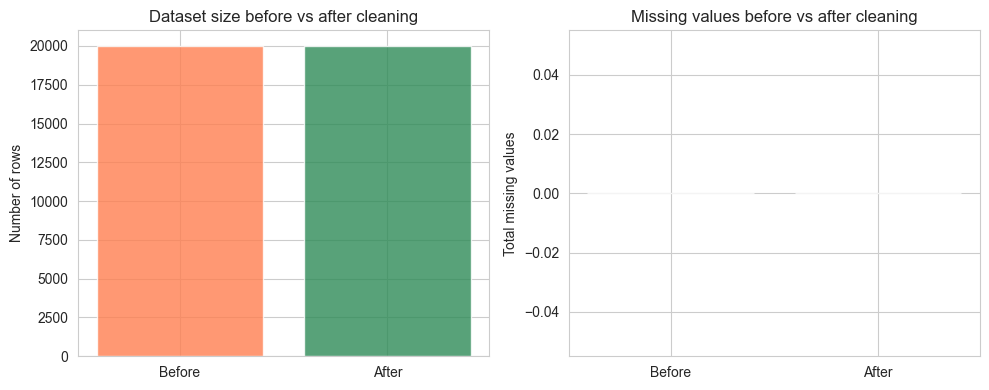

In [ ]:
# Purpose: Clean df → df_clean (drop missing target, fill missing, cap outliers); save loan_cleaned.csv; plot before/after
import numpy as np

# Data cleaning: before state
shape_before = df.shape
missing_before = df.isnull().sum().sum()

df_clean = df.copy()

# Drop rows with missing target (we need LoanApproved for classification)
if TARGET_CLASS in df_clean.columns:
    df_clean = df_clean.dropna(subset=[TARGET_CLASS])

# Identify numeric and categorical columns (exclude target and date)
exclude = {TARGET_CLASS, TARGET_SCORE, "ApplicationDate"}
numeric_cols = [c for c in df_clean.select_dtypes(include=[np.number]).columns if c not in exclude]
categorical_cols = [c for c in df_clean.select_dtypes(include=["object", "category"]).columns if c not in exclude]

# Fill numeric missing with median
for col in numeric_cols:
    if col in df_clean.columns and df_clean[col].isnull().any():
        med = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(med)

# Fill categorical missing with mode
for col in categorical_cols:
    if col in df_clean.columns and df_clean[col].isnull().any():
        mode_val = df_clean[col].mode()
        df_clean[col] = df_clean[col].fillna(mode_val.iloc[0] if len(mode_val) else "Unknown")

# Optional: cap numeric outliers (1.5*IQR)
for col in numeric_cols:
    if col not in df_clean.columns:
        continue
    Q1, Q3 = df_clean[col].quantile(0.25), df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    if IQR > 0:
        low, high = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        df_clean[col] = df_clean[col].clip(low, high)

print("After cleaning - shape:", df_clean.shape)
print("Missing:\n", df_clean.isnull().sum()[df_clean.isnull().sum() > 0] if df_clean.isnull().sum().any() else "None")

# Save cleaned dataset to datasets folder
cleaned_path = DATASETS_DIR / "loan_cleaned.csv"
df_clean.to_csv(cleaned_path, index=False)
print(f"\nCleaned data saved to: {cleaned_path}")

# Data engineering: before vs after cleaning visualization
fig_clean, ax_clean = plt.subplots(1, 2, figsize=(10, 4))
ax_clean[0].bar(["Before", "After"], [shape_before[0], df_clean.shape[0]], color=["coral", "seagreen"], alpha=0.8)
ax_clean[0].set_ylabel("Number of rows")
ax_clean[0].set_title("Dataset size before vs after cleaning")
missing_after = df_clean.isnull().sum().sum()
ax_clean[1].bar(["Before", "After"], [missing_before, missing_after], color=["coral", "seagreen"], alpha=0.8)
ax_clean[1].set_ylabel("Total missing values")
ax_clean[1].set_title("Missing values before vs after cleaning")
plt.tight_layout()
plt.show()

## 6. Preprocess and split

**Purpose:** Build feature matrix `X` and targets `y` (classification); label-encode categoricals and target; split into train/validation (80/20, stratified); fit `StandardScaler` and produce `X_train_scaled`, `X_val_scaled`. Defines `feature_cols`, `scaler`, `le_target`.

In [ ]:
# Purpose: Build X, y; encode categoricals and target; train/val split; fit scaler → X_train_scaled, X_val_scaled
# Install scikit-learn if missing (or run Section 1 first)
try:
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import LabelEncoder, StandardScaler
except ModuleNotFoundError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "scikit-learn"])
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import LabelEncoder, StandardScaler

# Features: all numeric + encoded categorical, excluding targets and ApplicationDate
exclude_feat = {TARGET_CLASS, TARGET_SCORE, "ApplicationDate"}
feature_numeric = [c for c in numeric_cols if c in df_clean.columns and c not in exclude_feat]
feature_categorical = [c for c in categorical_cols if c in df_clean.columns and c not in exclude_feat]
feature_cols = feature_numeric + feature_categorical

X = df_clean[feature_numeric].copy()
for c in feature_categorical:
    X[c] = LabelEncoder().fit_transform(df_clean[c].astype(str))

y_class = df_clean[TARGET_CLASS]
# Encode target (e.g. Approved/Denied or 1/0) to 0/1
le_target = LabelEncoder()
y = le_target.fit_transform(y_class.astype(str))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Feature columns:", feature_cols)
print("Train size:", X_train.shape[0], "Validation size:", X_val.shape[0])
print("Class mapping:", dict(zip(le_target.classes_, le_target.transform(le_target.classes_))))

Feature columns: ['Age', 'AnnualIncome', 'CreditScore', 'Experience', 'LoanAmount', 'LoanDuration', 'NumberOfDependents', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'EmploymentStatus', 'EducationLevel', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose']
Train size: 16000 Validation size: 4000
Class mapping: {'0': np.int64(0), '1': np.int64(1)}


---
## Model 1: Loan Approval & Denial

**What we use to train this model:**
- **Target:** `LoanApproved` (binary: Approved / Denied)
- **Features:** All numeric and categorical columns from the cleaned dataset (excluding target and date), scaled with `StandardScaler` and label-encoded
- **Algorithm:** Random Forest Classifier — 100 trees, max depth 12, Gini impurity
- **Train/validation:** 80/20 stratified split


### Model 1 — Train


In [ ]:
# Purpose: Train Random Forest classifier (model_rf); print train/validation accuracy
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42)
model_rf.fit(X_train_scaled, y_train)

train_acc_rf = model_rf.score(X_train_scaled, y_train)
val_acc_rf = model_rf.score(X_val_scaled, y_val)
print(f"Train accuracy: {train_acc_rf:.4f}")
print(f"Validation accuracy: {val_acc_rf:.4f}")


Train accuracy: 0.9907
Validation accuracy: 0.9243


### Model 1 — Save


In [ ]:
# Save Model 1 (Loan Approval classifier) and shared artifacts
import joblib
OUTPUT_DIR = Path("loan_default_risk_model")
OUTPUT_DIR.mkdir(exist_ok=True)
joblib.dump(model_rf, OUTPUT_DIR / "loan_default_classifier.pkl")
joblib.dump(le_target, OUTPUT_DIR / "label_encoder.pkl")
joblib.dump(scaler, OUTPUT_DIR / "scaler.pkl")
joblib.dump(feature_cols, OUTPUT_DIR / "feature_columns.pkl")
print("Model 1 saved to", OUTPUT_DIR)


Model 1 saved to loan_default_risk_model


### Model 1 — Visualizations (confusion matrix & performance metrics)


Performance metrics (Model 1 — RF Classifier):
  Accuracy:  0.9243
  Precision: 0.9229
  Recall:    0.9243
  F1-score:  0.9229

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95      3044
           1       0.88      0.79      0.83       956

    accuracy                           0.92      4000
   macro avg       0.91      0.88      0.89      4000
weighted avg       0.92      0.92      0.92      4000

Confusion matrix:
 [[2940  104]
 [ 199  757]]


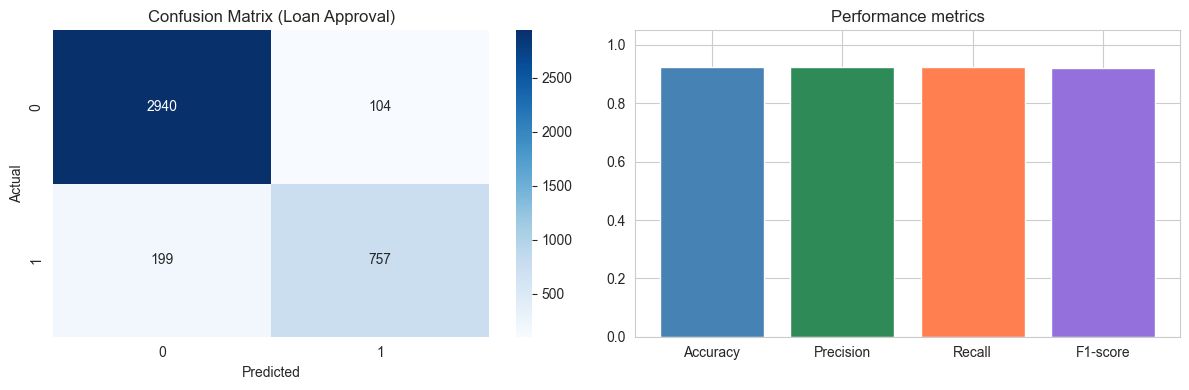

In [ ]:
# Purpose: Evaluate model_rf on validation set — metrics, classification report, confusion matrix, plots
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_rf = model_rf.predict(X_val_scaled)

acc = accuracy_score(y_val, y_pred_rf)
prec = precision_score(y_val, y_pred_rf, average="weighted", zero_division=0)
rec = recall_score(y_val, y_pred_rf, average="weighted", zero_division=0)
f1 = f1_score(y_val, y_pred_rf, average="weighted", zero_division=0)
print("Performance metrics (Model 1 — RF Classifier):")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall:    {rec:.4f}")
print(f"  F1-score:  {f1:.4f}")
print("\nClassification report:\n", classification_report(y_val, y_pred_rf, target_names=le_target.classes_))
print("Confusion matrix:\n", confusion_matrix(y_val, y_pred_rf))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
cm = confusion_matrix(y_val, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le_target.classes_, yticklabels=le_target.classes_, ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("Confusion Matrix (Loan Approval)")
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
values = [acc, prec, rec, f1]
axes[1].bar(metrics, values, color=["steelblue", "seagreen", "coral", "mediumpurple"])
axes[1].set_ylim(0, 1.05)
axes[1].set_title("Performance metrics")
plt.tight_layout()
plt.show()


### Model 1 — Test (load and run sample predictions)


In [ ]:
# Test Model 1: load and run sample predictions
import joblib
OUTPUT_DIR = Path("loan_default_risk_model")
model_1 = joblib.load(OUTPUT_DIR / "loan_default_classifier.pkl")
le_loaded = joblib.load(OUTPUT_DIR / "label_encoder.pkl")
n_test = 5
X_sample = X_val_scaled[:n_test]
y_true = y_val[:n_test]
pred = model_1.predict(X_sample)
pred_labels = le_loaded.inverse_transform(pred)
true_labels = le_loaded.inverse_transform(y_true)
print("=== Model 1: Loan Approval (sample predictions) ===")
for i in range(n_test):
    print(f"  Sample {i+1}: Actual={true_labels[i]}, Predicted={pred_labels[i]}")
print(f"  Accuracy on sample: {(pred == y_true).mean():.2%}")


=== Model 1: Loan Approval (sample predictions) ===
  Sample 1: Actual=0, Predicted=0
  Sample 2: Actual=0, Predicted=1
  Sample 3: Actual=1, Predicted=1
  Sample 4: Actual=0, Predicted=0
  Sample 5: Actual=0, Predicted=0
  Accuracy on sample: 80.00%


---
## Model 2: Credit Score Risk Assessment

**What we use to train this model:**
- **Target:** `RiskScore` (continuous; higher = higher default risk)
- **Features:** Same scaled features as Model 1 (only rows with non-missing RiskScore)
- **Algorithm:** Random Forest Regressor — 100 trees, max depth 12, MSE
- **Train/validation:** 80/20 split on the RiskScore subset


### Model 2 — Train


In [ ]:
# Purpose: Train RiskScore regressor (risk_score_model) on rows with RiskScore; set X_risk_val, y_risk_val for eval
from sklearn.ensemble import RandomForestRegressor

risk_score_model = None
X_risk_val = y_risk_val = None  # for evaluation cell

if TARGET_SCORE not in df_clean.columns:
    print("RiskScore not in dataset; skipping risk assessment model.")
else:
    mask_risk = df_clean[TARGET_SCORE].notna()
    n_risk = mask_risk.sum()
    print(f"Rows with RiskScore: {n_risk} (of {len(df_clean)})")

    if n_risk < 50:
        print("Too few samples for risk score model; skipping.")
    else:
        X_all_scaled = scaler.transform(X)
        X_risk = X_all_scaled[mask_risk]
        y_risk = df_clean.loc[mask_risk, TARGET_SCORE].values

        X_risk_train, X_risk_val, y_risk_train, y_risk_val = train_test_split(
            X_risk, y_risk, test_size=0.2, random_state=42
        )

        risk_score_model = RandomForestRegressor(n_estimators=100, max_depth=12, random_state=42)
        risk_score_model.fit(X_risk_train, y_risk_train)
        print("RiskScore model trained.")


Rows with RiskScore: 20000 (of 20000)
RiskScore model trained.


### Model 2 — Save


In [ ]:
# Save Model 2 (RiskScore regressor)
if risk_score_model is not None:
    joblib.dump(risk_score_model, OUTPUT_DIR / "risk_score_regressor.pkl")
    print("Model 2 saved to", OUTPUT_DIR)
else:
    print("Model 2 not trained; skip save.")


Model 2 saved to loan_default_risk_model


### Model 2 — Visualizations (performance metrics & actual vs predicted)


Performance metrics (Model 3 — RiskScore Regressor):
  MAE:  1.9385
  RMSE: 2.9256
  R²:   0.8621


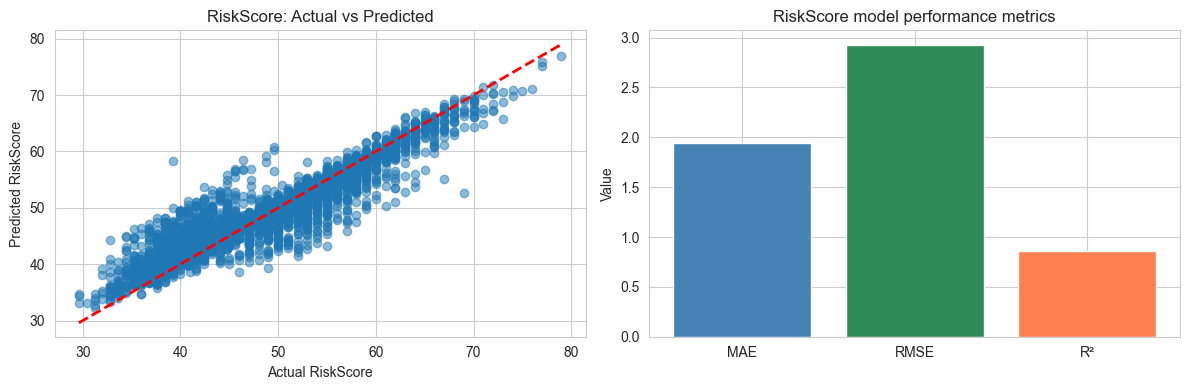

In [ ]:
# Purpose: Evaluate risk_score_model — MAE, RMSE, R² and actual vs predicted + metrics plots
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

if risk_score_model is not None and X_risk_val is not None:
    y_risk_pred = risk_score_model.predict(X_risk_val)
    mae_r = mean_absolute_error(y_risk_val, y_risk_pred)
    rmse_r = mean_squared_error(y_risk_val, y_risk_pred) ** 0.5
    r2_r = r2_score(y_risk_val, y_risk_pred)
    print("Performance metrics (Model 3 — RiskScore Regressor):")
    print(f"  MAE:  {mae_r:.4f}")
    print(f"  RMSE: {rmse_r:.4f}")
    print(f"  R²:   {r2_r:.4f}")

    fig, axes_r = plt.subplots(1, 2, figsize=(12, 4))
    axes_r[0].scatter(y_risk_val, y_risk_pred, alpha=0.5)
    axes_r[0].plot([y_risk_val.min(), y_risk_val.max()], [y_risk_val.min(), y_risk_val.max()], "r--", lw=2)
    axes_r[0].set_xlabel("Actual RiskScore")
    axes_r[0].set_ylabel("Predicted RiskScore")
    axes_r[0].set_title("RiskScore: Actual vs Predicted")
    metrics_r = ["MAE", "RMSE", "R²"]
    values_r = [mae_r, rmse_r, max(0, r2_r)]
    axes_r[1].bar(metrics_r, values_r, color=["steelblue", "seagreen", "coral"])
    axes_r[1].set_ylabel("Value")
    axes_r[1].set_title("RiskScore model performance metrics")
    plt.tight_layout()
    plt.show()
else:
    print("RiskScore model not trained; skipping evaluation.")


### Model 2 — Test (load and run sample predictions)


In [ ]:
# Test Model 2: load and run sample predictions
if (OUTPUT_DIR / "risk_score_regressor.pkl").exists():
    risk_model = joblib.load(OUTPUT_DIR / "risk_score_regressor.pkl")
    pred_risk = risk_model.predict(X_val_scaled[:n_test])
    print("=== Model 2: RiskScore (sample predictions) ===")
    for i in range(n_test):
        print(f"  Sample {i+1}: Predicted RiskScore = {pred_risk[i]:.2f}")
else:
    print("=== Model 2: not saved (skipped). ===")


=== Model 2: RiskScore (sample predictions) ===
  Sample 1: Predicted RiskScore = 60.21
  Sample 2: Predicted RiskScore = 48.41
  Sample 3: Predicted RiskScore = 40.05
  Sample 4: Predicted RiskScore = 58.69
  Sample 5: Predicted RiskScore = 53.61


---
## Model 3: Loan Recommendation

**What we use to train this model:**
- **Target:** `LoanAmount` (continuous; recommended loan amount)
- **Features:** Same scaled features; **training data = approved applications only**
- **Algorithm:** Random Forest Regressor — 100 trees, max depth 12, MSE
- **Train/validation:** 80/20 split on the approved-applications subset


### Model 3 — Train


C:\Users\Hp\AppData\Local\Temp\ipykernel_26976\436507695.py:17: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  feature_categorical_amt = [c for c in feature_cols_amt if c in df_clean.select_dtypes(include=["object", "category"]).columns]
C:\Users\Hp\AppData\Local\Temp\ipykernel_26976\436507695.py:17: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and si

Model 3 (Loan Amount) trained.
Performance metrics (Model 4 — Loan Amount Regressor):
  MAE:  512.01
  RMSE: 1056.21
  R²:   0.9855


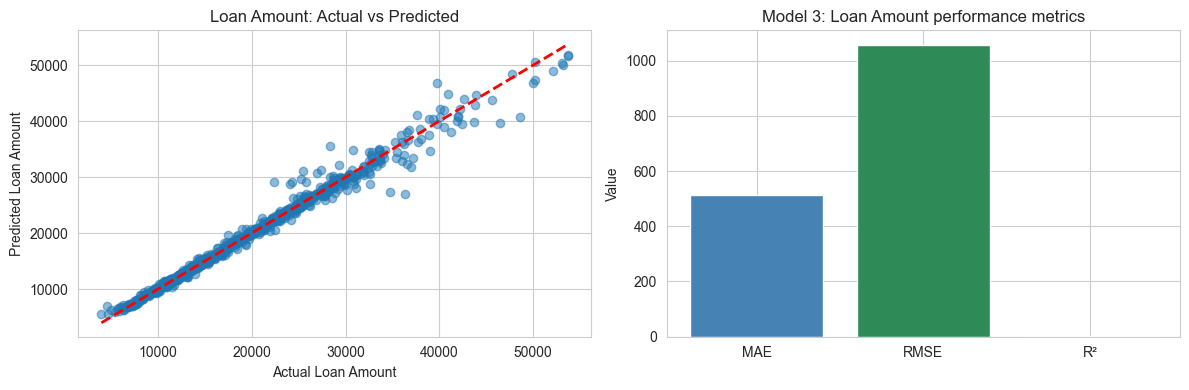

In [ ]:
# Purpose: Train Loan Amount regressor (amount_model) on approved rows; then evaluate and plot
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

amount_model = None
X_amt_val = None
y_amt_val = None

if "LoanAmount" in df_clean.columns and TARGET_CLASS in df_clean.columns:
    mask_approved = (df_clean[TARGET_CLASS] == 1)
    n_approved = mask_approved.sum()
    if n_approved >= 20:
        feature_cols_amt = [c for c in feature_cols if c != "LoanAmount"]
        feature_categorical_amt = [c for c in feature_cols_amt if c in df_clean.select_dtypes(include=["object", "category"]).columns]
        X_amt = df_clean.loc[mask_approved, feature_cols_amt].copy()
        for c in feature_categorical_amt:
            le_amt = LabelEncoder()
            le_amt.fit(df_clean[c].astype(str))
            X_amt[c] = le_amt.transform(X_amt[c].astype(str))
        y_amt = df_clean.loc[mask_approved, "LoanAmount"].values
        X_amt_train, X_amt_val, y_amt_train, y_amt_val = train_test_split(X_amt, y_amt, test_size=0.2, random_state=42)
        scaler_amt = StandardScaler()
        X_amt_train_scaled = scaler_amt.fit_transform(X_amt_train)
        X_amt_val_scaled = scaler_amt.transform(X_amt_val)
        amount_model = RandomForestRegressor(n_estimators=100, max_depth=12, random_state=42)
        amount_model.fit(X_amt_train_scaled, y_amt_train)
        X_amt_val = X_amt_val_scaled
        print("Model 3 (Loan Amount) trained.")
    else:
        print("Not enough approved rows for Loan Amount model.")
else:
    print("LoanAmount or LoanApproved not in df_clean; skipping Model 3 train.")

# Evaluate and visualize
if amount_model is not None and X_amt_val is not None:
    y_amt_pred = amount_model.predict(X_amt_val)
    mae_a = mean_absolute_error(y_amt_val, y_amt_pred)
    rmse_a = mean_squared_error(y_amt_val, y_amt_pred) ** 0.5
    r2_a = r2_score(y_amt_val, y_amt_pred)
    print("Performance metrics (Model 4 — Loan Amount Regressor):")
    print(f"  MAE:  {mae_a:.2f}")
    print(f"  RMSE: {rmse_a:.2f}")
    print(f"  R²:   {r2_a:.4f}")

    fig, axes_a = plt.subplots(1, 2, figsize=(12, 4))
    axes_a[0].scatter(y_amt_val, y_amt_pred, alpha=0.5)
    axes_a[0].plot([y_amt_val.min(), y_amt_val.max()], [y_amt_val.min(), y_amt_val.max()], "r--", lw=2)
    axes_a[0].set_xlabel("Actual Loan Amount")
    axes_a[0].set_ylabel("Predicted Loan Amount")
    axes_a[0].set_title("Loan Amount: Actual vs Predicted")
    metrics_a = ["MAE", "RMSE", "R²"]
    values_a = [mae_a, rmse_a, max(0, r2_a)]
    axes_a[1].bar(metrics_a, values_a, color=["steelblue", "seagreen", "coral"])
    axes_a[1].set_ylabel("Value")
    axes_a[1].set_title("Model 3: Loan Amount performance metrics")
    plt.tight_layout()
    plt.show()
else:
    print("Loan Amount model not trained; skipping evaluation.")


### Model 3 — Save


In [ ]:
# Save Model 3 (Loan Amount regressor)
if amount_model is not None:
    joblib.dump(amount_model, OUTPUT_DIR / "loan_amount_regressor.pkl")
    print("Model 3 (Loan Recommendation) saved to", OUTPUT_DIR)
else:
    print("Model 3 not trained; skip save.")


Model 3 (Loan Recommendation) saved to loan_default_risk_model


### Model 3 — Visualizations (performance metrics & actual vs predicted)


In [ ]:
# Purpose: Save model_rf, model_mlp, risk_score_model, amount_model, scaler, le_target, feature_cols to .pkl
import joblib

OUTPUT_DIR = Path("loan_default_risk_model")
OUTPUT_DIR.mkdir(exist_ok=True)

# Save all models and artifacts as .pkl
joblib.dump(model_rf, OUTPUT_DIR / "loan_default_classifier.pkl")
joblib.dump(model_mlp, OUTPUT_DIR / "mlp_classifier.pkl")
joblib.dump(le_target, OUTPUT_DIR / "label_encoder.pkl")
joblib.dump(scaler, OUTPUT_DIR / "scaler.pkl")
joblib.dump(feature_cols, OUTPUT_DIR / "feature_columns.pkl")
if globals().get("risk_score_model") is not None:
    joblib.dump(risk_score_model, OUTPUT_DIR / "risk_score_regressor.pkl")
if globals().get("amount_model") is not None:
    joblib.dump(amount_model, OUTPUT_DIR / "loan_amount_regressor.pkl")

print("Saved to", OUTPUT_DIR)
print("Files:", list(OUTPUT_DIR.glob("*")))


Saved to loan_default_risk_model
Files: [WindowsPath('loan_default_risk_model/feature_columns.pkl'), WindowsPath('loan_default_risk_model/label_encoder.pkl'), WindowsPath('loan_default_risk_model/loan_amount_regressor.pkl'), WindowsPath('loan_default_risk_model/loan_default_classifier.pkl'), WindowsPath('loan_default_risk_model/mlp_classifier.pkl'), WindowsPath('loan_default_risk_model/risk_score_regressor.pkl'), WindowsPath('loan_default_risk_model/scaler.pkl')]


### Model 3 — Test (load and run sample predictions)


In [ ]:
# Test Model 3: load and run sample predictions (model expects 32 features — feature_cols minus LoanAmount)
if (OUTPUT_DIR / "loan_amount_regressor.pkl").exists():
    amt_model = joblib.load(OUTPUT_DIR / "loan_amount_regressor.pkl")
    # Amount model was trained on feature_cols without LoanAmount; use same columns from X_val_scaled
    idx_amt = [i for i, c in enumerate(feature_cols) if c != "LoanAmount"]
    X_amt_test = X_val_scaled[:n_test][:, idx_amt]
    pred_amt = amt_model.predict(X_amt_test)
    print("=== Model 3: Loan Amount (sample predictions) ===")
    for i in range(n_test):
        print(f"  Sample {i+1}: Predicted Loan Amount = {pred_amt[i]:,.0f}")
else:
    print("=== Model 3: not saved (skipped). ===")


=== Model 3: Loan Amount (sample predictions) ===
  Sample 1: Predicted Loan Amount = 49,026
  Sample 2: Predicted Loan Amount = 5,601
  Sample 3: Predicted Loan Amount = 17,035
  Sample 4: Predicted Loan Amount = 51,759
  Sample 5: Predicted Loan Amount = 18,564


---
*Notebook complete. Each model is trained, saved, visualized, and tested in its own section.*
